In [1]:
import warnings
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

from scipy import stats

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
rc = {
    "stats.information_criterion": "waic",
    'stats.ic_scale': 'deviance',
    'stats.hdi_prob': 0.89
}
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams.update(rc)

In [3]:
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'
data = pd.read_csv(os.path.join(data_dir, "rugged.csv"), delimiter=";")

In [4]:
data.shape

(234, 51)

In [5]:
data.loc[:, 'loggdp'] = np.log(data.rgdppc_2000)
dd = data.dropna(subset=['loggdp']).copy()
dd.loc[:, 'loggdp_std'] = dd['loggdp'] / dd['loggdp'].mean()
dd.loc[:, 'rugged_std'] = dd['rugged'] / dd['rugged'].max()
print(dd.loggdp_std.describe(), dd.rugged_std.describe())

count    170.000000
mean       1.000000
std        0.136959
min        0.721556
25%        0.885214
50%        1.007176
75%        1.113081
max        1.287361
Name: loggdp_std, dtype: float64 count    170.000000
mean       0.214960
std        0.188402
min        0.000484
25%        0.071308
50%        0.157933
75%        0.315584
max        1.000000
Name: rugged_std, dtype: float64


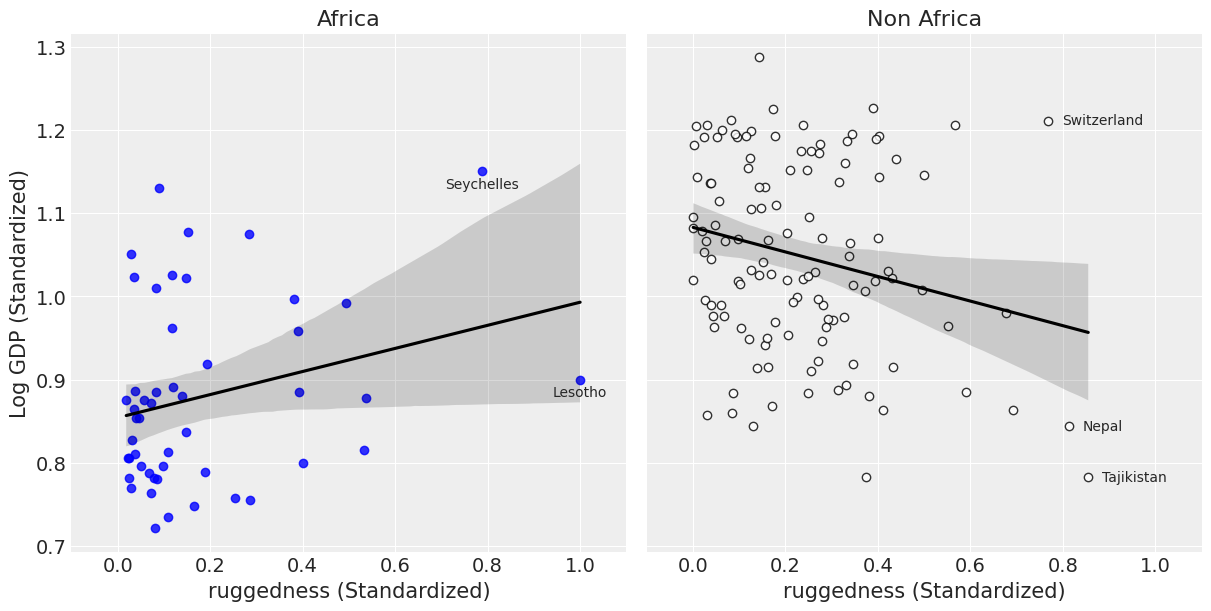

In [6]:
_, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.regplot(dd.loc[dd['cont_africa'] == 1]['rugged_std'], 
            dd.loc[dd['cont_africa'] == 1]['loggdp_std'], 
            scatter_kws={"color": "b"}, line_kws={"color": "k"}, ax=axs[0])
sns.regplot(dd.loc[dd['cont_africa'] == 0]['rugged_std'], 
            dd.loc[dd['cont_africa'] == 0]['loggdp_std'],             
            scatter_kws={"edgecolor": "k", "facecolor": "w"}, line_kws={"color": "k"}, ax=axs[1])
axs[0].set_ylabel("Log GDP (Standardized)")
axs[1].set_ylabel("")
axs[0].set_title("Africa")
axs[1].set_title("Non Africa")

for _, africa in dd.loc[(dd['cont_africa'] == 1) & (dd['rugged_std'] > 0.7)].iterrows():
    axs[0].text(africa['rugged_std'], africa['loggdp_std'] - 0.02, africa['country'], ha="center")
    
for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["loggdp_std"],
        non_africa["country"],
        va="center",
    )
for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (Standardized)")    

In [7]:
with pm.Model() as m81:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + b*(dd.rugged_std - 0.215)  # 0.215 is the mean of rugged
    log_gdp_std = pm.Normal("log_gdp_std", mu=mu, sigma=sigma, shape=dd.shape[0])
    m81_prior = pm.sample_prior_predictive()
    
with pm.Model() as m81_lt:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)
    mu = a + b*(dd.rugged_std - 0.215)  # 0.215 is the mean of rugged
    log_gdp_std = pm.Normal("log_gdp_std", mu=mu, sigma=sigma, observed=dd.loggdp_std)
    m81_lt_prior = pm.sample_prior_predictive()
    m81_lt_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


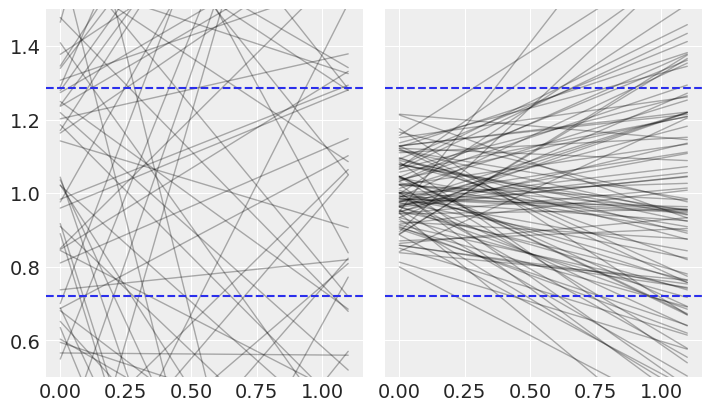

In [8]:
n = 100
rugged_plot = np.linspace(0, 1.1)

_, axs = plt.subplots(1, 2, figsize=(7,4), constrained_layout=True, sharey=True)

axs[0].plot(rugged_plot, m81_prior['a'][:n] + m81_prior['b'][:n]*rugged_plot.reshape(-1, 1), color="k", alpha=0.3, lw=1);
axs[1].plot(rugged_plot, m81_lt_prior['a'][:n] + m81_lt_prior['b'][:n]*rugged_plot.reshape(-1, 1), color="k", alpha=0.3, lw=1);

for ax in axs:
    ax.axhline(dd.loggdp_std.min(), linestyle="--")
    ax.axhline(dd.loggdp_std.max(), linestyle="--")
    ax.set_ylim(0.5, 1.5)

In [9]:
az.summary(m81_lt_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.09,0.09
sigma,0.14,0.01,0.13,0.15


In [10]:
cid = pd.Categorical(dd.cont_africa)

with pm.Model() as m82:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)
    sigma = pm.Exponential("sigma", 1)
    mu = a[cid] + b*(dd.rugged_std - 0.215)  # 0.215 is the mean of rugged
    loggdp_std = pm.Normal("log_gdp_std", mu=mu, sigma=sigma, observed=dd.loggdp_std)
    m82_trace = pm.sample()
    
az.compare({"m81": m81_lt_trace, "m82": m82_trace})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/home/telescreen/Softwares/miniconda3/envs/data/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m82,0,-252.07,4.21393,0,1,13.2317,0,True,deviance
m81,1,-188.816,2.59782,63.2544,1.31902e-07,14.7916,14.5938,False,deviance


In [11]:
az.summary(m82_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.85,0.91
b,-0.05,0.05,-0.12,0.03
sigma,0.11,0.01,0.10,0.12


In [12]:
with m82:
    m82_post = pm.sample_posterior_predictive(m82_trace, vars=[a, b, sigma])
diffa0a1 = m82_post['a'][:, 1] - m82_post['a'][:, 0]
az.hdi(diffa0a1)

array([-0.20104665, -0.13849387])

Text(0, 0.5, 'log GDP')

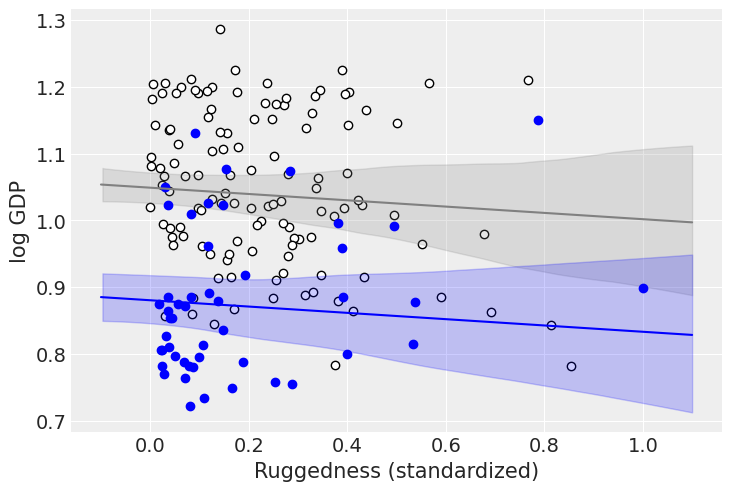

In [13]:
_, ax = plt.subplots()
rugged_plot = np.linspace(-.1, 1.1)
ax.scatter(dd.loc[cid == 0, "rugged_std"], 
           dd.loc[cid == 0, "loggdp_std"],
          label="Not Africa", facecolor="w", lw=1, edgecolor="k")
pred0 = m82_trace['a'][:, 0] + m82_trace['b'] * rugged_plot.reshape(-1, 1)
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, fill_kwargs={"alpha": 0.2}, ax=ax)

ax.scatter(dd.loc[cid == 1, "rugged_std"], 
           dd.loc[cid == 1, "loggdp_std"],
          label="Africa", facecolor="b", lw=1)
pred1 = m82_trace['a'][:, 1] + m82_trace['b'] * rugged_plot.reshape(-1, 1)
ax.plot(rugged_plot, pred1.mean(1), color="blue")
az.plot_hdi(rugged_plot, pred1.T, color="blue", hdi_prob=0.97, fill_kwargs={"alpha": 0.2}, ax=ax)

ax.set_xlabel("Ruggedness (standardized)")
ax.set_ylabel("log GDP")

In [14]:
with pm.Model() as m83:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)
    sigma = pm.Exponential("sigma", 1)
    mu = a[cid] + b[cid]*(dd.rugged_std - 0.215)  # 0.215 is the mean of rugged
    loggdp_std = pm.Normal("log_gdp_std", mu=mu, sigma=sigma, observed=dd.loggdp_std)
    m83_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [17]:
az.compare({"m81": m81_lt_trace, "m82": m82_trace, "m83": m83_trace}, ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m83,0,-259.138,4.99456,0,0.860385,12.4353,0,False,deviance
m82,1,-252.031,4.23366,7.10669,0.139615,14.7418,6.43542,False,deviance
m81,2,-188.813,2.5994,70.3248,7.20771e-09,14.1231,14.8543,False,deviance


In [16]:
az.summary(m83_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.06,-0.23,-0.06
b[1],0.13,0.07,0.02,0.25
sigma,0.11,0.01,0.10,0.12


In [24]:
tulips = data = pd.read_csv(os.path.join(data_dir, "tulips.csv"), delimiter=";")
tulips.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [26]:
tulips.loc[:, 'blooms_std'] = tulips.loc[:, 'blooms'] / tulips.loc[:, 'blooms'].max()
tulips.loc[:, 'water_cent'] = tulips.loc[:, 'water'] / tulips.loc[:, 'water'].mean()
tulips.loc[:, 'shade_cent'] = tulips.loc[:, 'shade'] / tulips.loc[:, 'shade'].mean()

In [27]:
tulips.describe()

,water,shade,blooms,blooms_std,water_cent,shade_cent
count,27.00000,27.00000,27.000000,27.000000,27.000000,27.000000
mean,2.00000,2.00000,128.993704,0.356671,1.000000,1.000000
std,0.83205,0.83205,92.683923,0.256274,0.416025,0.416025
min,1.00000,1.00000,0.000000,0.000000,0.500000,0.500000
25%,1.00000,1.00000,71.115000,0.196635,0.500000,0.500000
50%,2.00000,2.00000,111.040000,0.307029,1.000000,1.000000
75%,3.00000,3.00000,190.300000,0.526185,1.500000,1.500000
max,3.00000,3.00000,361.660000,1.000000,1.500000,1.500000


In [37]:
1 - stats.norm.cdf(1, loc=0.5, scale=.25) + stats.norm.cdf(0, loc=0.5, scale=.25)

0.0455002638963584

In [38]:
with pm.Model() as m84:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    mu = a + bw*tulips.water_cent + bs*tulips.shade_cent
    sigma = pm.Exponential("sigma", 1)
    bloom_std = pm.Normal("bloom_std", mu, sigma, observed=tulips.blooms_std)
    m84_trace = pm.sample()

with pm.Model() as m85:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)
    mu = a + bw*tulips.water_cent + bs*tulips.shade_cent + bws*tulips.water_cent*tulips.shade_cent
    sigma = pm.Exponential("sigma", 1)
    bloom_std = pm.Normal("bloom_std", mu, sigma, observed=tulips.blooms_std)
    m85_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
